In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch as tn
from scipy.integrate import quad
import time

# Import files
from constants import *
from pdfpy import *
from functions import  d_sigma
from rotation import *

LHAPDF 6.5.4 loading /home/ahmed/miniconda3/share/LHAPDF/NNPDF31_nnlo_as_0118/NNPDF31_nnlo_as_0118_0000.dat
NNPDF31_nnlo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 303600


In [2]:
# Quarks
e = 0.302
quarks = [
    (2, 2/3*e, 'u', 1/2),
     #(1, -1/3*e, 'd', -1/2),
    # (3, -1/3*e, 's', -1/2),
    # (4, 2/3*e, 'c', 1/2),
    # (5, -1/3*e, 'b', -1/2),
    #  (6, 2/3*e, 't', 1/2),
]

# List of quark properties and couplings
quark_couplings = []

for flavor, e_f, name, I3 in quarks:
    g_fR = -e_f * sin2th_w
    g_fL = I3 - e_f * sin2th_w
    
    # Rounding to 4 decimal places
    e_f = round(e_f, 4)
    g_fR = round(g_fR, 4)
    g_fL = round(g_fL, 4)
    
    quark_couplings.append((flavor, e_f, g_fR, g_fL))

print(quark_couplings)

[(2, 0.2013, -0.0449, 0.4551)]


In [3]:
#Don't foregt the metric convenction (+, -, -, -)

CL = tn.tensor([
    [0, 0, 0, 0],
    [0, 0.01, 0, 0],
    [0, 0, -0.01, 0],
    [0,0, 0, 0]
], dtype=tn.float32)

CR = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)

C0 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)


In [4]:
# import time

# # Get the current Unix time
# current_unix_time = int(time.time())

# print(current_unix_time)
# print(start_time)

In [5]:

# p1 = 1 / np.sqrt(2) * tn.tensor([1,1, 1,1], dtype=tn.float32)

# p2 = 1 / np.sqrt(2) * tn.tensor([1,-1, -1,-1], dtype=tn.float32)

# # Initialize the variables

# # start_time = datetime.now(timezone.utc).replace(microsecond=0, second=0, minute= 0)  # Start from the beginning of the current hour
# start_time = int(time.time())
# end_time = start_time + int(timedelta(days=2).total_seconds())
# step = timedelta(hours=1)  # Step of 12 hours

# # Lists to store the times and contr matrix elements
# times = []
# contr_elementsL = []
# contr_elementsR = []

# current_time = start_time
# while current_time < end_time:
#     # Convert current_time to a timestamp
#     current_datetime = datetime.fromtimestamp(current_time)
#     time_utc = current_datetime.timestamp()
    
#     # Calculate omega_t
#     omega_t_sid = omega_utc * time_utc + 3.2830  # Example value, adjust as needed

#     # Construct the complete rotation matrix from SCF to CMS
#     R_matrix = R_y(latitude) @ R_x(azimuth) @ R_z @ R_Z(omega_t_sid)
    
#     # Compute contrL and contrR
#     contrL = np.matmul(CL, R_matrix)
#     contrR = np.matmul(CR, R_matrix)

#     # Convert contrL and contrR to PyTorch tensors
#     contrL_tensor = tn.tensor(contrL, dtype=tn.float32)
#     contrR_tensor = tn.tensor(contrR, dtype=tn.float32)
    
#     # Compute results
#     resultL = tn.dot(p1, tn.mv(contrL_tensor, p2))
#     resultR = tn.dot(p1, tn.mv(contrR_tensor, p2))

#     # Record the times and contr matrix elements
#     times.append(current_time)
#     contr_elementsL.append(contrL_tensor)
#     contr_elementsR.append(contrR_tensor)

#     # Move to the next time step
#     current_time += int(step.total_seconds())
# # Convert the list of contr elements to a NumPy array for easier indexing
# # contr_elementsL = np.array(contr_elementsL)
# # contr_elementsR = np.array(contr_elementsR)


In [6]:
# Define the constant tensors once
sqrt_half = 1 / np.sqrt(2)
p1 = sqrt_half * tn.tensor([1, 1, 1, 1], dtype=tn.float32)
p2 = sqrt_half * tn.tensor([1, -1, -1, -1], dtype=tn.float32)

# Precompute total number of steps
start_time = int(time.time())
end_time = start_time + int(timedelta(days=2).total_seconds())
step_seconds = int(timedelta(hours=1).total_seconds())
num_steps = (end_time - start_time) // step_seconds

# Lists to store the times and contr matrix elements
times = []
contr_elementsL = []
contr_elementsR = []


# Precompute parts of the rotation matrices that do not depend on omega_t_sid
R_y_lat = R_y(latitude)
R_x_azi = R_x(azimuth)

# Main loop
current_time = start_time
for _ in range(num_steps):
    # Convert current_time to a timestamp
    current_datetime = datetime.fromtimestamp(current_time)
    time_utc = current_datetime.timestamp()

    # Calculate omega_t
    omega_t_sid = omega_utc * time_utc + 3.2830  # Example value, adjust as needed

    # Construct the complete rotation matrix from SCF to CMS
    R_Z_omega = R_Z(omega_t_sid)
    R_matrix = R_y_lat @ R_x_azi @ R_Z_omega

    # Compute contrL and contrR using matrix multiplication
    contrL = np.matmul(CL, R_matrix)
    contrR = np.matmul(CR, R_matrix)

    # Convert contrL and contrR to PyTorch tensors (using in-place operations)
    contrL_tensor = tn.tensor(contrL, dtype=tn.float32).clone().detach()
    contrR_tensor = tn.tensor(contrR, dtype=tn.float32).clone().detach()

    # Compute results (using in-place operations)
    resultL = tn.dot(p1, tn.mv(contrL_tensor, p2))
    resultR = tn.dot(p1, tn.mv(contrR_tensor, p2))

    # Record the times and contr matrix elements
    times.append(current_time)
    contr_elementsL.append(contrL_tensor)
    contr_elementsR.append(contrR_tensor)

    # Move to the next time step
    current_time += step_seconds

# Convert the list of contr elements to a NumPy array for easier indexing if needed
# contr_elementsL = np.array(contr_elementsL)
# contr_elementsR = np.array(contr_elementsR)


/tmp/ipykernel_26433/2583148079.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  contrL_tensor = tn.tensor(contrL, dtype=tn.float32).clone().detach()
/tmp/ipykernel_26433/2583148079.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  contrR_tensor = tn.tensor(contrR, dtype=tn.float32).clone().detach()


In [7]:
# # Integration and plotting
# Q_val = np.linspace(60, 70, 50)
# a = 60 # Start of the Q range
# b = 70  # End of the Q range
# nbins = 1  # Number of bins
# # Example momenta for protons


# Q_bins = np.linspace(a, b, nbins + 1)

# # Integrate d_sigma over each bin
# # Integrate d_sigma over each bin
# results = [d_sigma(Q**2, Cc, Ch, p1, p2, 1, quark_couplings) 
#            for Cc, Ch, Q in zip(contr_elementsL, contr_elementsR, Q_val)]

# dsigma, dsigmaL, dsigmaR = zip(*results)



# def integrand(Q, CL, CR, p1, p2, n):
#     return d_sigma(Q**2,CL, CR, p1, p2, 1, quark_couplings)[0]
    
# sme_values = []
    
# for i in range(len(Q_bins) - 1):
#     Q_start = Q_bins[i]
#     Q_end = Q_bins[i + 1]
#     integral_sm, _ = quad(integrand, Q_start, Q_end, args=(C0, C0, p1, p2, 1))
#     for elemL, elemR in zip(contr_elementsL, contr_elementsR):
#             integral_sme, _ = quad(integrand, Q_start, Q_end, args=(elemR, elemL, p1, p2, 1))
#             sme_values.append(integral_sme)


In [8]:

from multiprocessing import Pool

# Define constants
Q_val = np.linspace(60, 70, 50)
a = 60  # Start of the Q range
b = 70  # End of the Q range
nbins = 1  # Number of bins

# Example momenta for protons
Q_bins = np.linspace(a, b, nbins + 1)

# Precompute results for d_sigma
results = [d_sigma(Q**2, Cc, Ch, p1, p2, 1, quark_couplings)
           for Cc, Ch, Q in zip(contr_elementsL, contr_elementsR, Q_val)]
dsigma, dsigmaL, dsigmaR = zip(*results)

# Define the integrand function
def integrand(Q, CL, CR, p1, p2, n, quark_couplings):
    return d_sigma(Q**2, CL, CR, p1, p2, n, quark_couplings)[0]

# Perform the SME integration in parallel
def parallel_integral(args):
    Q_start, Q_end, CL, CR, p1, p2, n, quark_couplings = args
    integral_sme, _ = quad(integrand, Q_start, Q_end, args=(CL, CR, p1, p2, n, quark_couplings))
    return integral_sme

# Prepare arguments for parallel processing
arguments = [(Q_bins[0], Q_bins[1], elemL, elemR, p1, p2, 1, quark_couplings)
             for elemL, elemR in zip(contr_elementsL, contr_elementsR)]

# Use a Pool to perform parallel integration
with Pool() as pool:
    sme_values = pool.map(parallel_integral, arguments)

# Perform the Standard Model integration once
Q_start = Q_bins[0]
Q_end = Q_bins[1]
integral_sm, _ = quad(integrand, Q_start, Q_end, args=(C0, C0, p1, p2, 1, quark_couplings))

# integral_sm now holds the result for the Standard Model integration


/home/ahmed/Desktop/test/functions.py:43: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(integrand, tau, 1)
/tmp/ipykernel_26433/3758866373.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral_sme, _ = quad(integrand, Q_start, Q_end, args=(CL, CR, p1, p2, n, quark_couplings))
/tmp/ipykernel_26433/3758866373.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being a

In [155]:
resultssm = [d_sigma(80**2, C0, C0, p1, p2, 1, quark_couplings)]
dsigmasm, dsigmaLsm, dsigmaRsm = zip(*resultssm)

resultssme = [d_sigma(80**2, Cc, Ch, p1, p2, 1, quark_couplings)
           for Cc, Ch, Q in zip(contr_elementsL, contr_elementsR, Q_val)]
dsigmasme, dsigmaLsme, dsigmaRsme = zip(*resultssme)


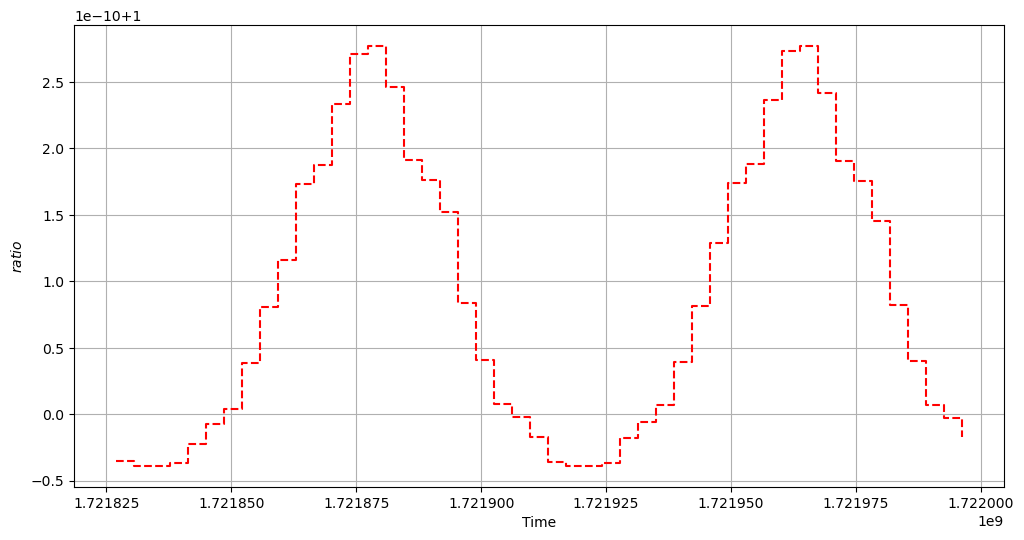

In [169]:
dratio = [t/dsigmasm[0] for t in dsigmasme]

plt.figure(figsize=(12, 6))

# Create the step plot
plt.step(times,  dratio, where='post', color='r', linestyle='--')
# plt.axhline(y=1, color='b', linestyle='-', label='y = 1')
# plt.plot(times, dsigma)
plt.xlabel('Time')
# plt.yscale('log')
plt.ylabel('$ratio$')
plt.grid('true')
# plt.title('differeintal cross section at Q=60 GeV')
# plt.savefig('intrsec.png')
plt.show()

In [161]:
print(dratio)

[0.9999999999645305, 0.9999999999612879, 0.9999999999611576, 0.9999999999629408, 0.99999999997785, 0.9999999999928666, 1.0000000000040152, 1.0000000000387341, 1.0000000000803517, 1.0000000001163378, 1.0000000001730454, 1.0000000001875553, 1.0000000002334544, 1.0000000002708203, 1.000000000277296, 1.0000000002460105, 1.0000000001913711, 1.0000000001761489, 1.0000000001520284, 1.0000000000832718, 1.000000000040866, 1.0000000000079319, 0.9999999999975793, 0.9999999999831313, 0.9999999999642619, 0.9999999999612688, 0.9999999999611715, 0.999999999963229, 0.9999999999820262, 0.9999999999937973, 1.0000000000065659, 1.0000000000389713, 1.0000000000810287, 1.000000000129088, 1.0000000001738485, 1.0000000001885687, 1.0000000002364287, 1.0000000002731997, 1.0000000002771865, 1.0000000002420104, 1.0000000001905764, 1.0000000001755474, 1.0000000001451317, 1.0000000000823124, 1.0000000000401559, 1.00000000000711, 0.9999999999970611, 0.9999999999828916]


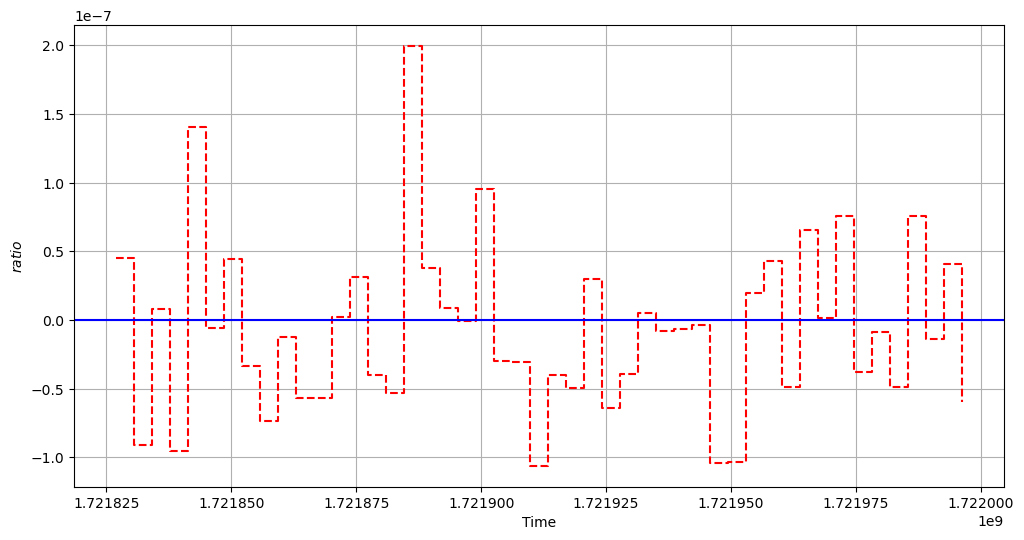

In [109]:
Q2 = np.linspace(17.5**2, 90**2, 100)
#human_readable_times = [datetime.fromtimestamp(ts) for ts in unix_times]  # Convert to datetime objects
ratio = [t/integral_sm for t in sme_values]
filtered = [value for index, value in enumerate(ratio) if index != 11]
filtimes = [value for index, value in enumerate(times) if index != 11]
plt.figure(figsize=(12, 6))

# Create the step plot
plt.step(filtimes,  [t-1 for t in filtered], where='post', color='r', linestyle='--')
plt.axhline(y=0, color='b', linestyle='-', label='y = 1')
# plt.plot(times, dsigma)
plt.xlabel('Time')
# plt.yscale('log')
plt.ylabel('$ratio$')
plt.grid('true')
# plt.title('differeintal cross section at Q=60 GeV')
# plt.savefig('intrsec.png')
plt.show()

In [51]:
print(np.delete(times, 24))

[1721826964 1721830564 1721834164 1721837764 1721841364 1721844964
 1721848564 1721852164 1721855764 1721859364 1721862964 1721866564
 1721870164 1721873764 1721877364 1721880964 1721884564 1721888164
 1721891764 1721895364 1721898964 1721902564 1721906164 1721909764
 1721916964 1721920564 1721924164 1721927764 1721931364 1721934964
 1721938564 1721942164 1721945764 1721949364 1721952964 1721956564
 1721960164 1721963764 1721967364 1721970964 1721974564 1721978164
 1721981764 1721985364 1721988964 1721992564 1721996164]


In [61]:
print([t/integral_sm for t in sme_values])
print([value for index, value in enumerate(ratio) if index != 2])

[1.0000000450481688, 0.9999999086778985, 1.0000000082309863, 0.9999999044844201, 1.0000001406662777, 0.9999999944502868, 1.000000044528101, 0.9999999667945667, 0.9999999262431126, 0.999999987968159, 0.9999999435406987, 1.000001113552699, 1.0000000023400353, 1.0000000310427233, 0.9999999603101845, 0.9999999471822865, 1.0000001998328731, 1.0000000382007421, 1.0000000089222596, 0.9999999996583847, 1.0000000955301218, 0.9999999704514039, 0.9999999696787163, 0.9999998939307143, 0.999999959939044, 0.9999999507880172, 1.0000000301996776, 0.9999999358371945, 0.9999999605665572, 1.000000004922639, 0.9999999922785355, 0.9999999934505436, 0.9999999963192061, 0.9999998960325917, 0.9999998966308564, 1.000000019963587, 1.0000000433148182, 0.9999999514897993, 1.0000000659279455, 1.0000000013952057, 1.0000000757678842, 0.9999999618628648, 0.9999999916335266, 0.9999999509117056, 1.0000000758585605, 0.9999999863148088, 1.0000000411565595, 0.9999999400825469]
[1.0000000450481688, 0.9999999086778985, 0.99

In [ ]:
# import torch
# import numpy as np

# # Define the covariant tensor C_{mu nu}
# CL = torch.tensor([
#     [0, 0, 0, 0],
#     [0, 0.01, 0, 0],
#     [0, 0, -0.01, 0],
#     [0, 0, 0, 00]
# ], dtype=torch.float32)

# # Define the metric tensors g^{mu alpha} and g^{nu beta}
# # For example, using Minkowski metric with signature (+, -, -, -)
# g = torch.tensor([
#     [1, 0, 0, 0],
#     [0, -1, 0, 0],
#     [0, 0, -1, 0],
#     [0, 0, 0, -1]
# ], dtype=torch.float32)

# # Raise indices of the covariant tensor CL using the metric tensors
# # First, apply the first metric tensor to raise the first index
# temp = torch.matmul(g, CL)  # g^{mu alpha} * C_{alpha nu}

# # Then apply the second metric tensor to raise the second index
# raised_tensor = torch.matmul(temp, g)  # g^{nu beta} * temp_{alpha beta}

# print(raised_tensor)


In [113]:
print(results)

[(102787029023.63045, 88180053886.52376, 14606975137.106684), (102392767908.81767, 88083745431.66327, 14309022477.154404), (102022542731.19177, 88003687950.88031, 14018854780.311464), (101675381343.92133, 87939407060.04352, 13735974283.877815), (101351657102.66345, 87891199408.22604, 13460457694.437403), (101049560612.13815, 87857729761.50858, 13191830850.629581), (100770889845.82059, 87840731971.93575, 12930157873.884834), (100513574699.95676, 87838507847.99527, 12675066851.961493), (100279091471.63673, 87852653705.53526, 12426437766.101473), (100066065349.51785, 87882017049.76984, 12184048299.74802), (99874828014.01357, 87927002049.01971, 11947825964.99385), (99705204583.59259, 87987643735.04105, 11717560848.551544), (99557099605.71179, 88063982461.05658, 11493117144.655214), (99430079287.59706, 88155803671.00757, 11274275616.58949), (99324914304.10562, 88264019744.39276, 11060894559.712866), (99240780525.87872, 88387867796.84435, 10852912729.034374), (99177622671.50998, 88527537864.